# Exercise 2: Data set, augmentation, and baseline
## Goals:
- Explore data
- Augment data
- Train a simple model and evaluate the effect of using augmented data


In this exercise we are going to explore how augmented data can be used in training and testing.

The code used in the exercise is based on the code already shown during the lecture. In this notebook you get the main code blocks to do the exercise. It helps to look at the code to get inspiration to solve the exercise. 

In [1]:
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt

## Load data
In this execercise we will be working with a CT data set from lungs which are acompanied by a list of labels to tell if the image is healthy or malign. The image slices are stored in a (3D) numpy array and the labels in a pandas data frame. [Pandas](https://pandas.pydata.org/docs/) is a libray that helps you to store tables of data that are searchable and slicable depending on different criteria.

__Note:__ Please uncompress the file ```ct_tiles.tif.zip``` before starting.

In [2]:
imgs = io.imread('ct_tiles.tif')
labels = pd.read_csv('malignancy.csv')
print('Image size: {0},{1},{2}'.format(imgs.shape[0],imgs.shape[1],imgs.shape[2]))
print('Labels {0}'.format(labels.malignancy.count() ))

Image size: 6691,64,64
Labels 6691


## What is the first thing to do after loading the data?

In [3]:
imgs.shape

(6691, 64, 64)

In [4]:
labels

,idx,malignancy
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
6686,6686,0
6687,6687,0
6688,6688,0
6689,6689,0


# Explore the data

### Look at the label distribution

<Axes: >

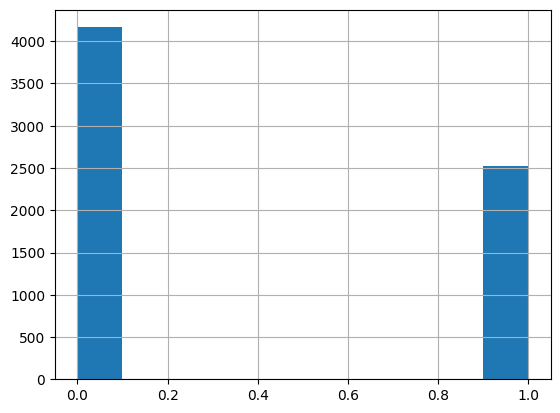

In [5]:
# TODO: What can we observe in the label distribution?
labels.malignancy.hist()

In [8]:
labels.malignancy.describe()

count    6691.000000
mean        0.377522
std         0.484803
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: malignancy, dtype: float64

In [9]:
y = labels.malignancy.values
y.shape

(6691,)

### Look at some slices

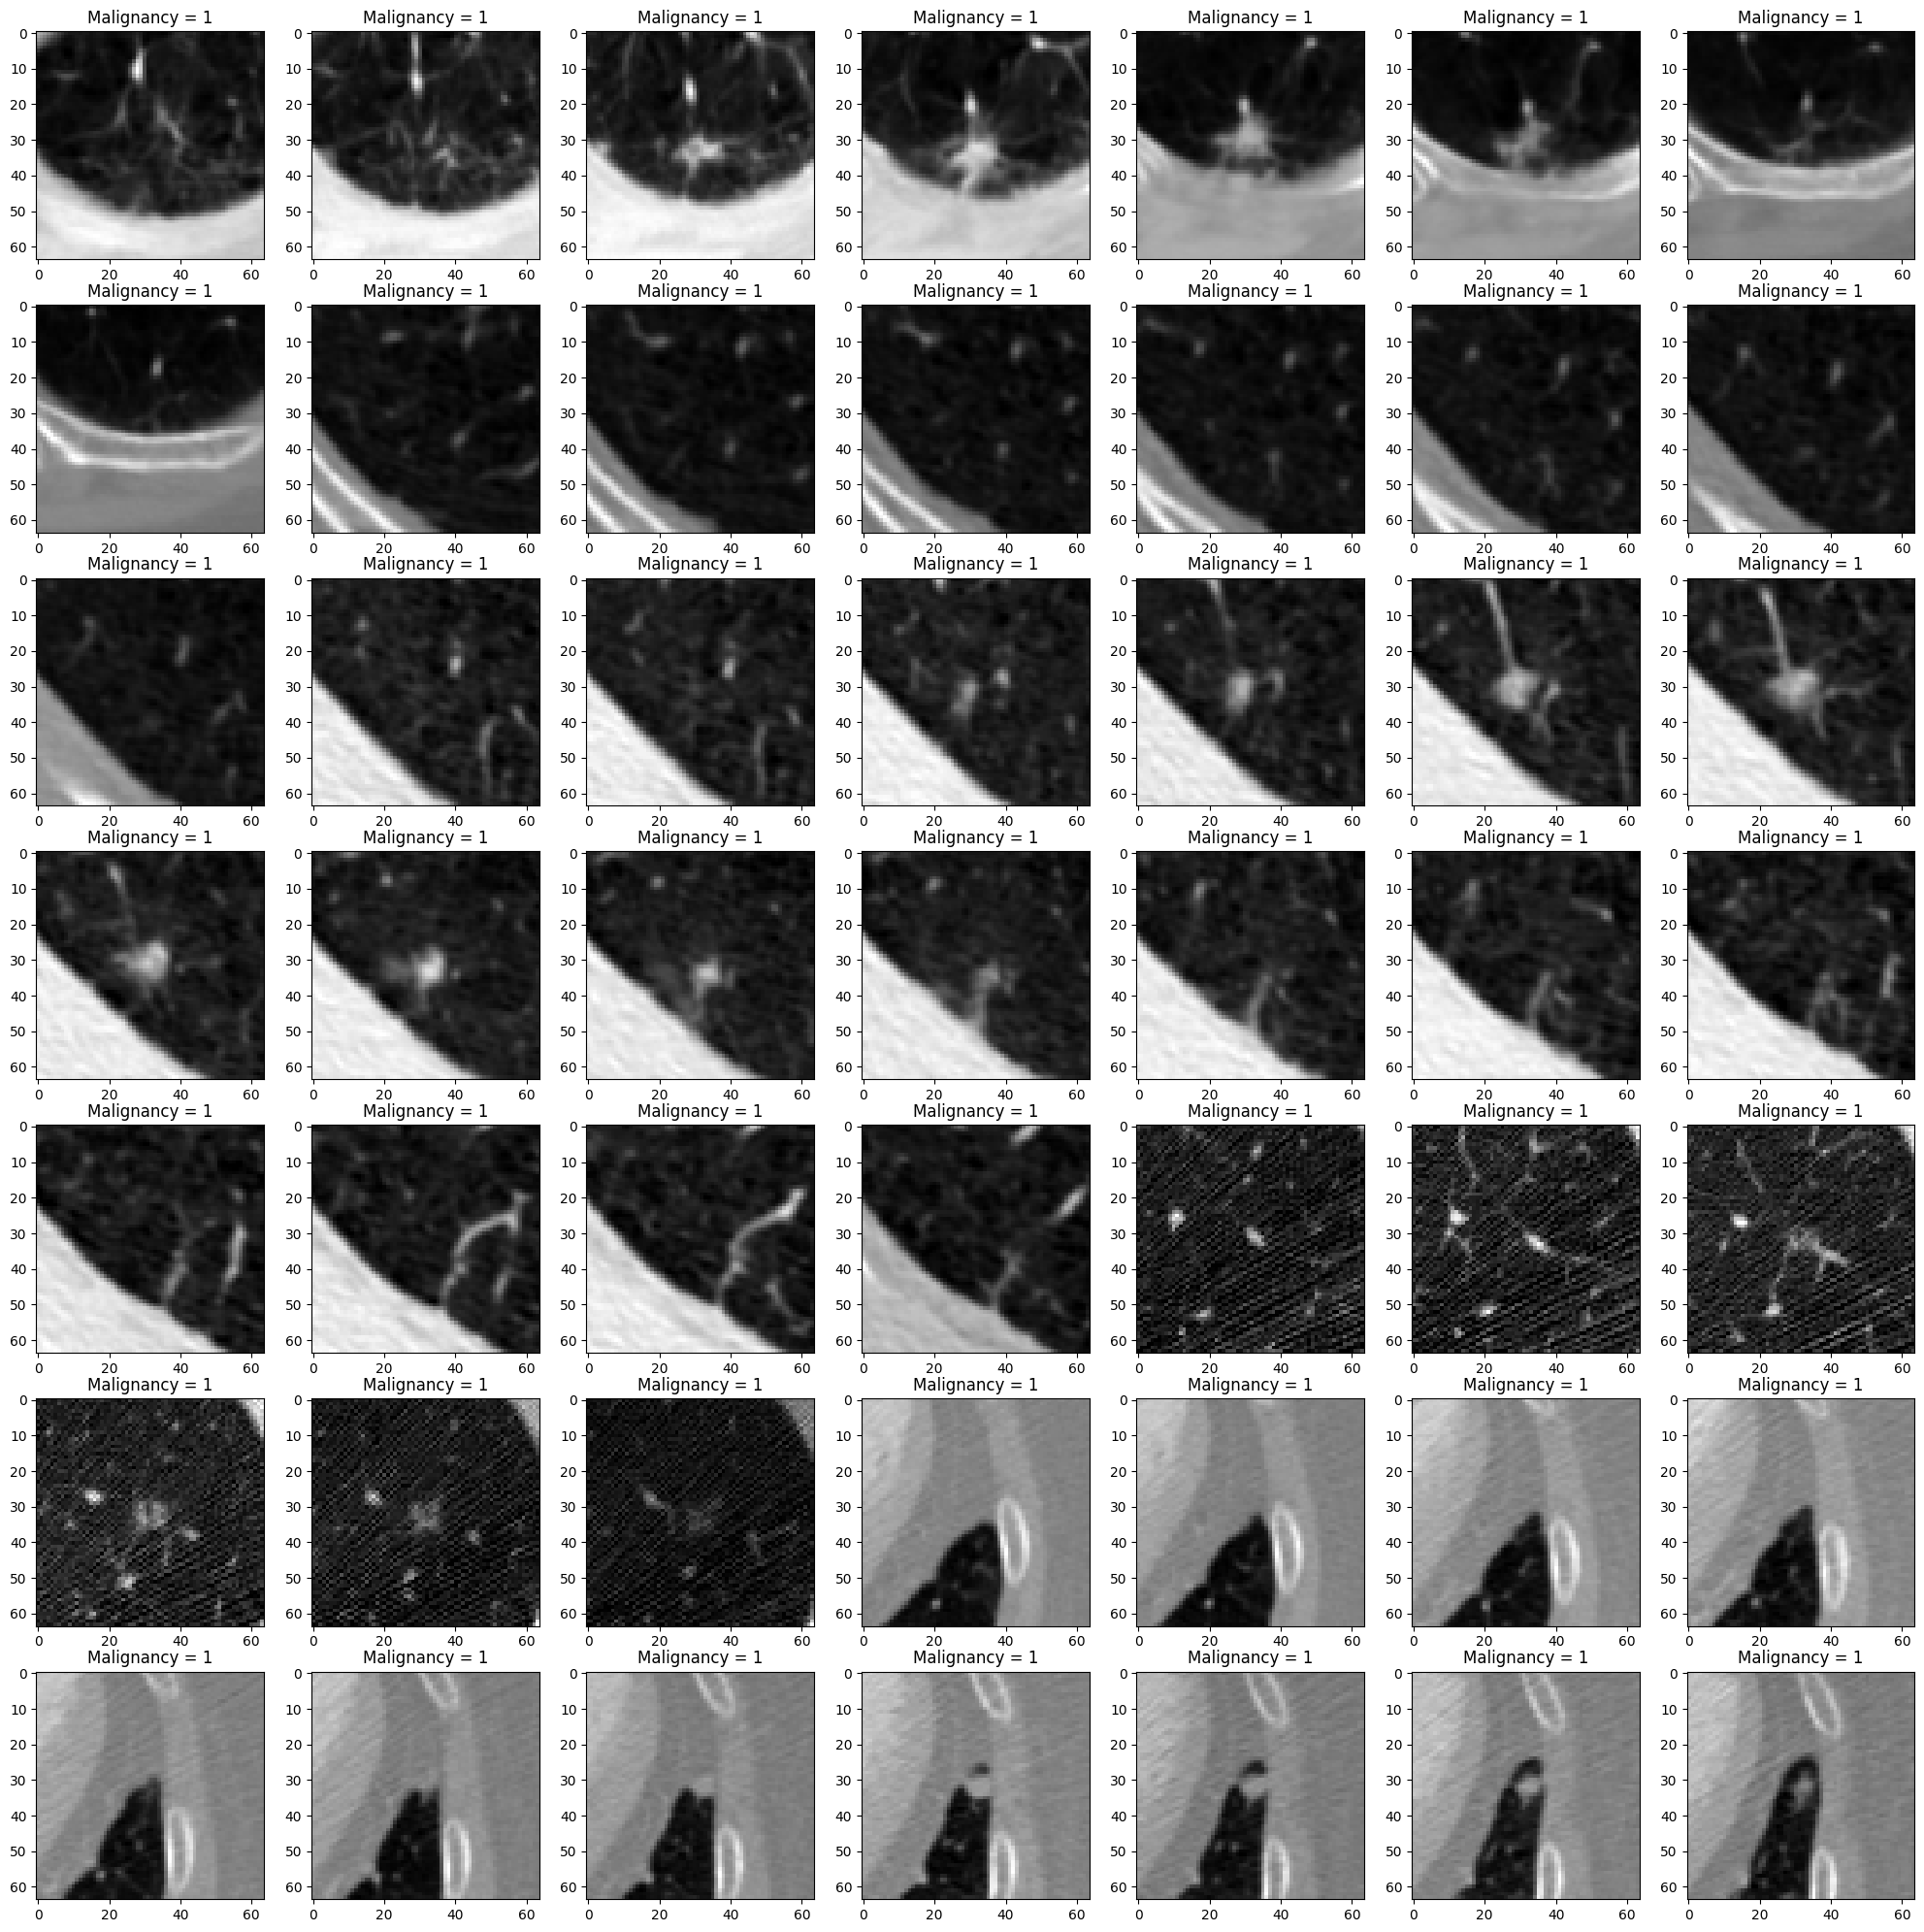

In [13]:
# TODO: What can we observe in the data array?
LABEL = 1
r = slice(0,49) if LABEL == 1 else slice(-49,None)
plt.figure(figsize=[25,25])
for idx,tile in enumerate(imgs[r]) :
    plt.subplot(7,7,idx+1)
    plt.imshow(tile, cmap='gray') 
    i = idx if LABEL == 1 else -49 + idx
    plt.title('Malignancy = {0}'.format(y[i]))

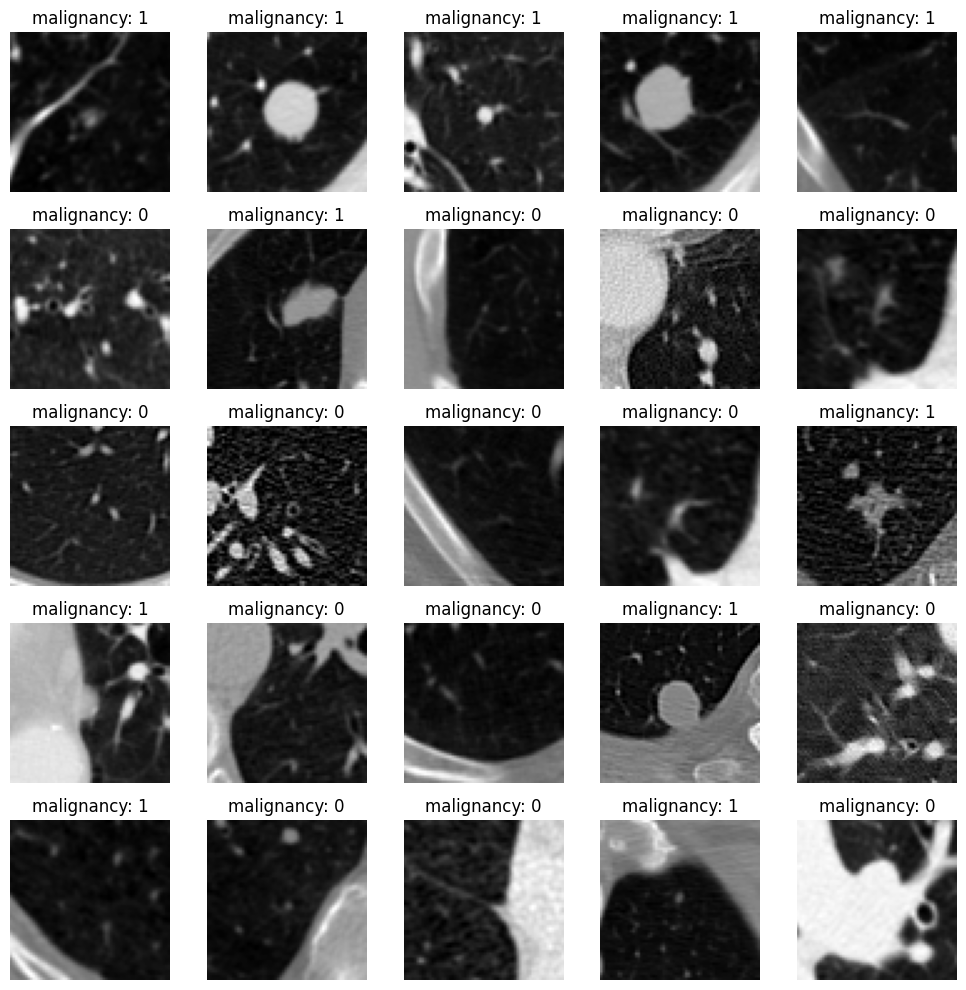

In [14]:

def plot_sample_images(images, labels, n=25):
    plt.figure(figsize=(10, 10))
    
    indices = np.random.choice(len(images), n, replace=False)  # Randomly select n images
    selected_images = images[indices]
    selected_labels = labels[indices]
    
    grid_size = int(n ** 0.5)  # Create a square grid
    for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img, cmap='gray')  # Use 'gray' for single-channel images
        plt.title(f"malignancy: {str(label)}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming your images are stored in `X` and labels in `y`
plot_sample_images(imgs, y)


## Augmenting the data
Let's create a data augmentation pipeline. The full range of readily available augmentations can be found here: https://github.com/albumentations-team/albumentations?tab=readme-ov-file#list-of-augmentations
We will be working with some simple augmentations like:
- rotation
- translation
- scaling
- shear
- flips
- blurring
- etc.

In [16]:
import albumentations as A

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(width=50, height=50),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=0.5),  # Width & height shift, zoom
    A.Affine(shear=(-20, 20), p=0.5),  # Shear transformation
    A.GaussianBlur(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize images
])




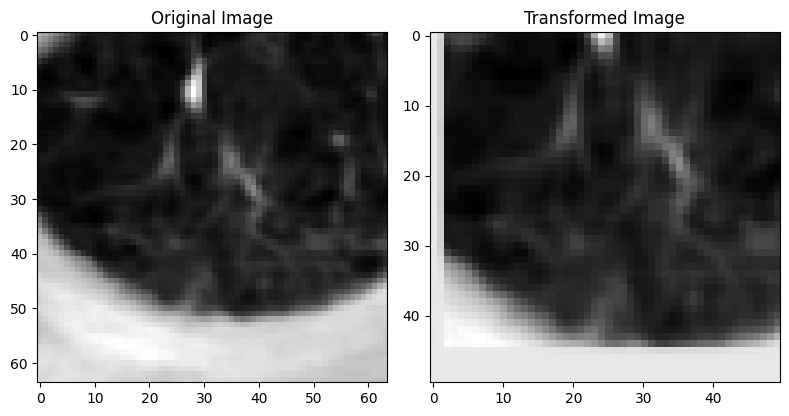

In [17]:
# TODO: WHich transformations do you see?
im = imgs[0]
transformed = transform(image=im)
transformed_image = transformed["image"]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray')
plt.title("Transformed Image")

plt.tight_layout()
plt.show()



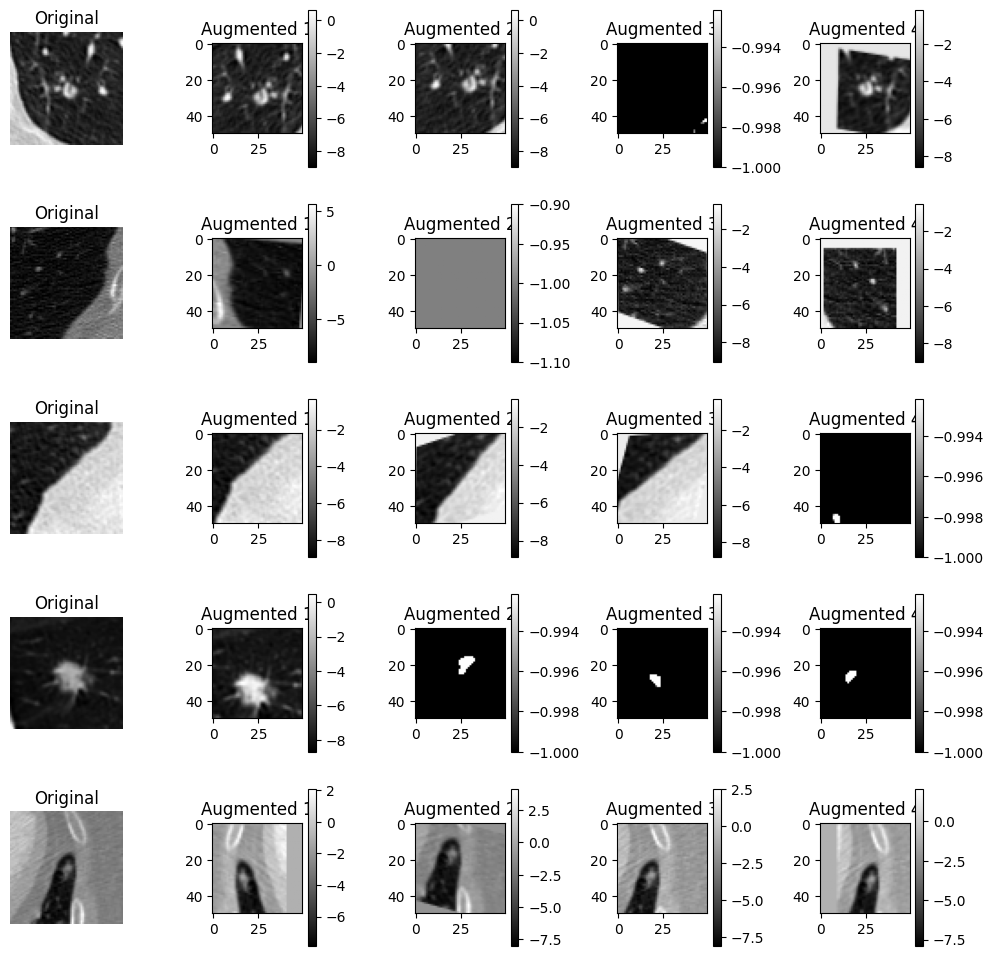

In [19]:
# Given a set of images, plot the image and in the same row plot 4 augmentations of the image
def plot_augmented_images(images, transform: A.Compose, n=5):
    plt.figure(figsize=(10, 10))
    
    indices = np.random.choice(len(images), n, replace=False)  # Randomly select n images
    selected_images = images[indices]
    
    grid_size = int(n ** 0.5)  # Create a square grid
    for i, img in enumerate(selected_images):
        plt.subplot(n, 5, i * 5 + 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        for j in range(4):
            transformed = transform(image=img)
            transformed_image = transformed["image"]
            plt.subplot(n, 5, i * 5 + j + 2)
            plt.imshow(transformed_image, cmap='gray')
            plt.title(f"Augmented {j + 1}")
            plt.colorbar()
            # plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming your images are stored in `X`
plot_augmented_images(imgs, transform, n=5)
        

## Testing baselines with augmented data
From the lectures you learned that in order to compare the performance of an algorithm, you need a baseline algorithm. Previously, you heard about two algorithms:
- Dummy classifier which uses the majority as prediction for any input data.
- Nearest neighbor that uses the nearest feature as prediction.

Below you get examples on the lung data.

### Dummy classifier

In [20]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy='most_frequent')
dc.fit(imgs, y)

DummyClassifier(strategy='most_frequent')

In [21]:
predictions = dc.predict(imgs)


### How to evaluate performance? Metrics:
- Accuracy
- Precision
- F1 score
- ...
- Quite comprehensive list: https://scikit-learn.org/stable/api/sklearn.metrics.html
Use case dependent!

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y, predictions)

0.6224779554625617

(array([   0.,    0.,    0.,    0.,    0., 6691.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

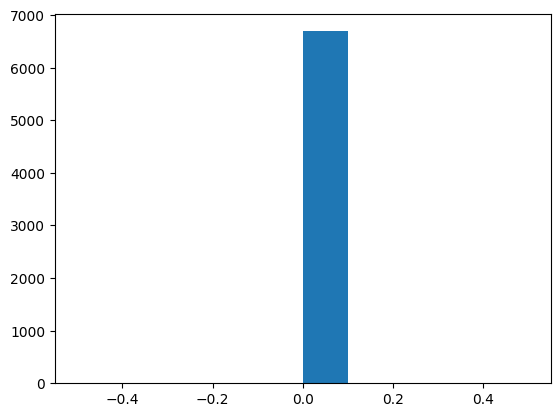

In [23]:
plt.hist(predictions)

In [24]:
1 - y.sum() / len(y)

np.float64(0.6224779554625617)

### Nearest neighbor

In [25]:
# TODO: Why do we reshape the images? What is the resulting shape?
from sklearn.neighbors import KNeighborsClassifier
neigh_class = KNeighborsClassifier(n_neighbors=1)
reshaped_imgs = imgs.reshape(imgs.shape[0], -1)
neigh_class.fit(reshaped_imgs, y)

KNeighborsClassifier(n_neighbors=1)

(array([4165.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2526.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

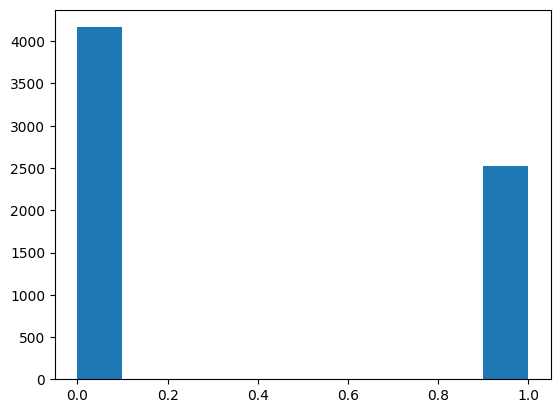

In [26]:
# predict on a few images
preds = neigh_class.predict(reshaped_imgs)
plt.hist(preds)

### Confusion matrix

In [27]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Stolen from: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return ax1

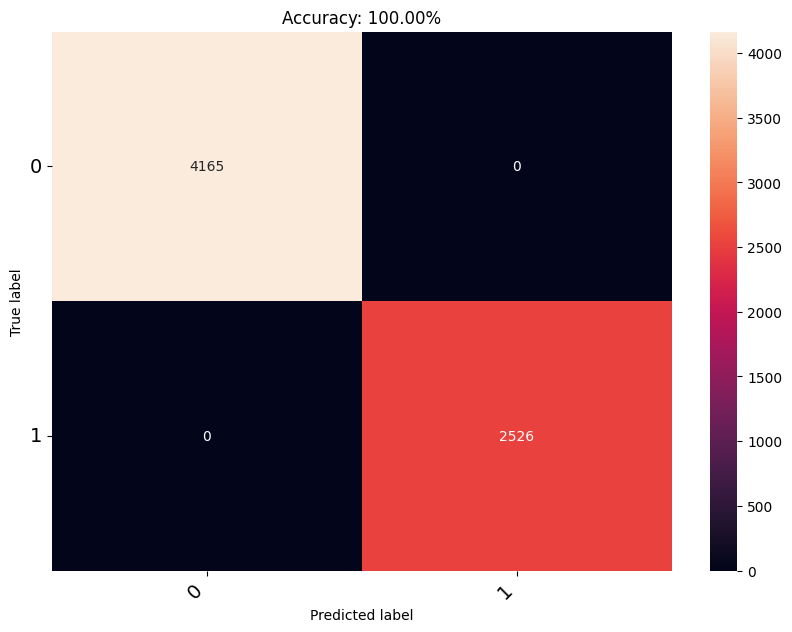

In [28]:
pred_values = neigh_class.predict(reshaped_imgs)
ax1 = print_confusion_matrix(confusion_matrix(y, pred_values), class_names=range(2))
ax1.set_title('Accuracy: {:2.2%}'.format(accuracy_score(y, pred_values)));

## Why did we get perfect accuracy? 
## What happens if we use K!=1?

## Exercise
1. Evaluate the nearest neighbour baseline "properly" in this notebook.
Complete the functions in `tasks.py` and pass the tests. You will have to:
2. Create a subset of the original datasets with 500 images. Create an augmented data set of 2500 images from the selected subset. Pay attention to obtaining a representative balance between healthy and malign samples. The augmented images should be of size 64,64.
3. Fit a KNNs classifier using 
    1. the original subset of 500 data samples. You should achieve >60% accuracy.
    2. the augmented dataset. You should achieve >70% accuracy.
    > Note: You will have to play with the number, type and hyperparameters of the augmentations and the kNN classifier.
    > Note: You will have to implement the functions to train, predict and evaluate the kNN model.
4. Compare the performance using the confusion matrix. Plot it on this notebook.

> Tip: Solve each of the tasks first on the notebook, so it is easier to see the input and output of the functions. Check the file `test_exercise2.py` and the docstrings of each function to get more information on how to implement them.

In [30]:
import tasks as t

Subset shapes - Data: (500, 64, 64), Labels: (500,)
Label distribution in subset: [311 189]
Augmented shapes - Data: (2500, 64, 64), Labels: (2500,)
Label distribution in augmented: [1555  945]
Train/Test split - Train: (400, 64, 64), Test: (100, 64, 64)
Augmented Train/Test split - Train: (2000, 64, 64), Test: (500, 64, 64)
Original data - k=1, Accuracy: 0.6500
Augmented data - k=1, Accuracy: 0.6760
Original data - k=3, Accuracy: 0.6800
Augmented data - k=3, Accuracy: 0.6600
Original data - k=5, Accuracy: 0.6100
Augmented data - k=5, Accuracy: 0.6660
Original data - k=7, Accuracy: 0.6000
Augmented data - k=7, Accuracy: 0.6600
Original data - k=9, Accuracy: 0.6100
Augmented data - k=9, Accuracy: 0.6480

Best model: k=3, data=original, accuracy=0.6800


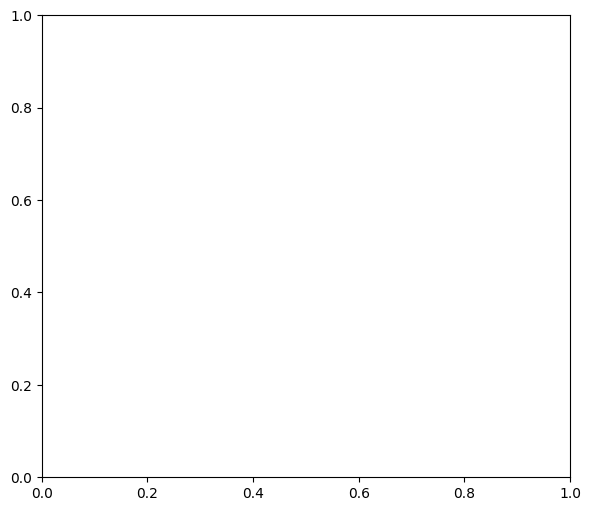

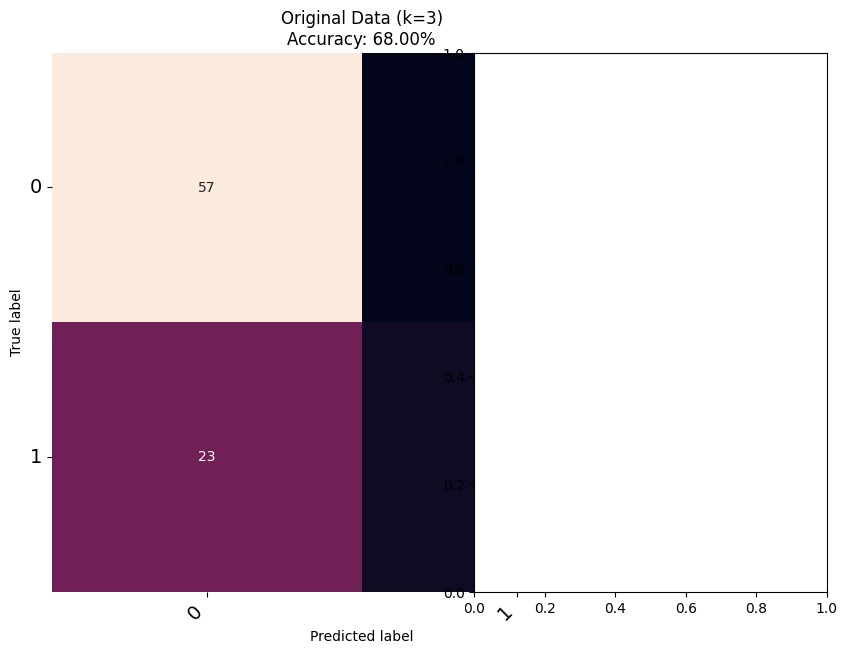

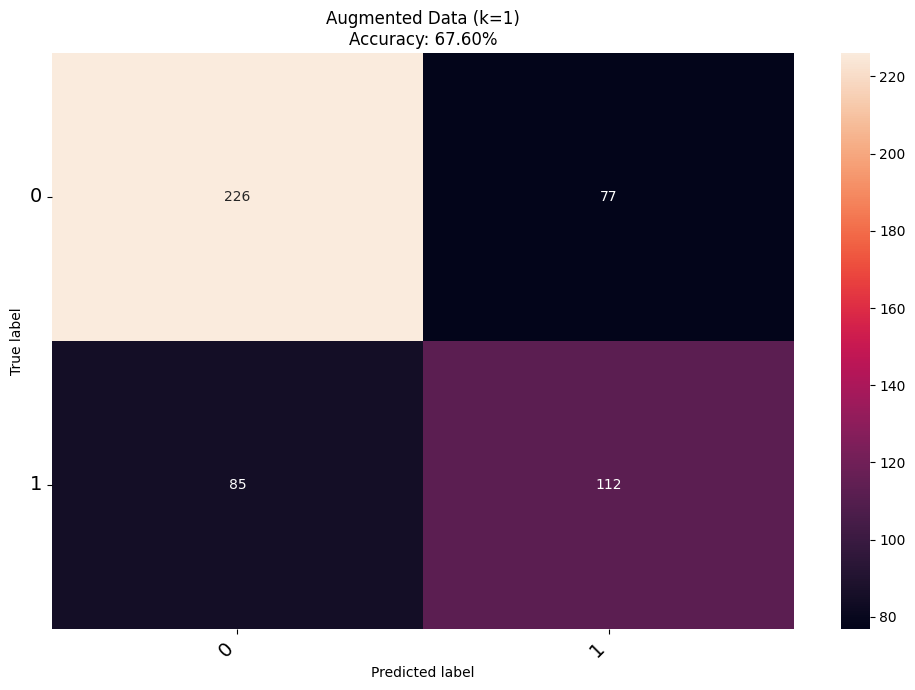

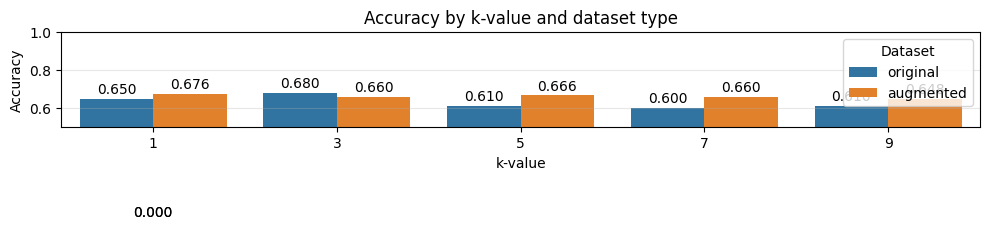

In [32]:
subset_data, subset_labels = t.create_dataset_subset(imgs, y, n=500)
print(f"Subset shapes - Data: {subset_data.shape}, Labels: {subset_labels.shape}")
print(f"Label distribution in subset: {np.bincount(subset_labels)}")

augmented_data, augmented_labels = t.augment_data(subset_data, subset_labels)
print(f"Augmented shapes - Data: {augmented_data.shape}, Labels: {augmented_labels.shape}")
print(f"Label distribution in augmented: {np.bincount(augmented_labels)}")

(train_data, train_labels), (test_data, test_labels) = t.split_train_test_dataset(
    subset_data, subset_labels, percentage=0.8, shuffle=True
)
print(f"Train/Test split - Train: {train_data.shape}, Test: {test_data.shape}")

(aug_train_data, aug_train_labels), (aug_test_data, aug_test_labels) = t.split_train_test_dataset(
    augmented_data, augmented_labels, percentage=0.8, shuffle=True
)
print(f"Augmented Train/Test split - Train: {aug_train_data.shape}, Test: {aug_test_data.shape}")

k_values = [1, 3, 5, 7, 9]
results = []

for k in k_values:
    # Train 
    knn = t.train_kNN(train_data, train_labels, k=k)
    
    # Predict 
    predictions = t.predict_kNN(knn, test_data)
    
    # Evaluate 
    accuracy = t.evaluate_predictions(test_labels, predictions, accuracy_score)
    
    results.append({"k": k, "data": "original", "accuracy": accuracy})
    print(f"Original data - k={k}, Accuracy: {accuracy:.4f}")
    
    # Train on augmented 
    aug_knn = t.train_kNN(aug_train_data, aug_train_labels, k=k)
    
    # Predict on augmented test
    aug_predictions = t.predict_kNN(aug_knn, aug_test_data)
    
    # Evaluate 
    aug_accuracy = t.evaluate_predictions(aug_test_labels, aug_predictions, accuracy_score)
    
    results.append({"k": k, "data": "augmented", "accuracy": aug_accuracy})
    print(f"Augmented data - k={k}, Accuracy: {aug_accuracy:.4f}")

# Get best model
best_result = max(results, key=lambda x: x["accuracy"])
print(f"\nBest model: k={best_result['k']}, data={best_result['data']}, accuracy={best_result['accuracy']:.4f}")

best_original = max([r for r in results if r["data"] == "original"], key=lambda x: x["accuracy"])
best_augmented = max([r for r in results if r["data"] == "augmented"], key=lambda x: x["accuracy"])

best_orig_knn = t.train_kNN(train_data, train_labels, k=best_original["k"])
orig_preds = t.predict_kNN(best_orig_knn, test_data)
orig_cm = confusion_matrix(test_labels, orig_preds)

best_aug_knn = t.train_kNN(aug_train_data, aug_train_labels, k=best_augmented["k"])
aug_preds = t.predict_kNN(best_aug_knn, aug_test_data)
aug_cm = confusion_matrix(aug_test_labels, aug_preds)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
ax1 = print_confusion_matrix(orig_cm, class_names=range(2))
ax1.set_title(f'Original Data (k={best_original["k"]})\nAccuracy: {best_original["accuracy"]:.2%}')

plt.subplot(1, 2, 2)
ax2 = print_confusion_matrix(aug_cm, class_names=range(2))
ax2.set_title(f'Augmented Data (k={best_augmented["k"]})\nAccuracy: {best_augmented["accuracy"]:.2%}')

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='k', y='accuracy', hue='data', data=results_df)
plt.title('Accuracy by k-value and dataset type')
plt.xlabel('k-value')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend(title='Dataset')
plt.grid(axis='y', alpha=0.3)

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height() + 0.01, 
        f'{bar.get_height():.3f}', 
        ha='center', va='bottom', rotation=0
    )

plt.tight_layout()
plt.show()